# SAA → Proxy Benchmark & Factor Analysis (Colab‑Ready)

In [107]:
!pip install pandas
!pip install yfinance
!pip install matplotlib
!pip install scipy
!pip install statsmodels


This notebook lets you:

**Step 1 — Proxy Benchmark**  
- Define a Strategic Asset Allocation (tickers & weights).  
- Choose a rebalance frequency (none/monthly/quarterly/annual) and transaction costs (bps).  
- Build a proxy benchmark time series using daily prices.  
- Track weights, turnover, and apply costs on rebalance days.

**Step 2 — Factor Analysis**  
- Diagnose key risk exposures using **ETF factor proxies** (default) suitable for multi‑asset portfolios.  
- Optional: switch to **academic equity factors** (Fama–French 5 + Momentum) if your SAA is equity‑heavy.  
- Run OLS and (optionally) constrained NNLS style analysis.  
- Get loadings, t‑stats, R²/Adj‑R², VIFs, and rolling exposures.  
- Plot exposures and residual diagnostics.

> **Note:** This notebook fetches data with `yfinance` (and optionally Ken French factors via `pandas_datareader`). It will work in Google Colab out of the box.


In [108]:

# === Setup & Installs ===
# If running locally, uncomment the pip installs. In Google Colab you can run as-is.

# !pip install yfinance pandas numpy statsmodels scipy pandas_datareader matplotlib

import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

from scipy.optimize import nnls
import statsmodels.api as sm

pd.options.display.max_columns = 200


In [109]:

# === Utility helpers ===

def to_period_end_index(dates: pd.DatetimeIndex, freq: str) -> pd.DatetimeIndex:
    """Return period-end dates for a given frequency within the provided date range."""
    if freq.lower() in ["none", "never", "n"]:
        return pd.DatetimeIndex([])
    if freq.lower() in ["monthly", "m"]:
        return pd.date_range(dates.min(), dates.max(), freq="M")
    if freq.lower() in ["quarterly", "q"]:
        return pd.date_range(dates.min(), dates.max(), freq="Q" )
    if freq.lower() in ["annual", "a", "y", "yearly"]:
        return pd.date_range(dates.min(), dates.max(), freq="A")
    raise ValueError(f"Unknown rebalance frequency: {freq}")


def normalize_weights(weights: Dict[str, float]) -> Dict[str, float]:
    w = pd.Series(weights, dtype=float)
    s = w.sum()
    if not np.isclose(s, 1.0):
        w = w / s
    return w.to_dict()


def compute_turnover(prev_w: pd.Series, next_w: pd.Series) -> float:
    """One-way turnover (L1/2)."""
    # Full turnover = sum(|Δw|); one-way = 0.5 * full
    return 0.5 * (prev_w.fillna(0.0) - next_w.fillna(0.0)).abs().sum()


def apply_tc_to_return(rebalance_turnover: float, gross_return: float, costs_bps: float) -> float:
    """Deduct transaction costs (bps) on rebalance day from the gross portfolio return."""
    tc = rebalance_turnover * (costs_bps / 10_000.0)
    return gross_return - tc


In [110]:

# === Step 1: Build Proxy Benchmark ===

@dataclass
class ProxyBenchmarkResult:
    prices: pd.DataFrame
    returns: pd.DataFrame
    port_ret: pd.Series
    port_nav: pd.Series
    weights: pd.DataFrame
    turnover: pd.Series
    rebalanced_on: pd.Series


def build_proxy_benchmark(
    tickers: Dict[str, float],
    start: str = "2015-01-01",
    end: Optional[str] = None,
    rebalance: str = "monthly",   # 'none', 'monthly', 'quarterly', 'annual'
    costs_bps: float = 0.0,
    price_field: str = "Adj Close",
    dropna: bool = True,
) -> ProxyBenchmarkResult:
    """
    Build a proxy benchmark from a Strategic Asset Allocation.

    Parameters
    ----------
    tickers : dict
        Mapping of ticker -> target weight. Will be normalized to sum to 1.
    start, end : str
        Date range for price history.
    rebalance : str
        'none'|'monthly'|'quarterly'|'annual'
    costs_bps : float
        Transaction costs in basis points applied on **rebalance days** based on one-way turnover.
    price_field : str
        Yahoo price field to use (e.g., 'Adj Close', 'Close').
    dropna : bool
        If True, will drop rows with any NA returns.

    Returns
    -------
    ProxyBenchmarkResult
    """
    tickers = normalize_weights(tickers)
    tickers_list = list(tickers.keys())

    data = yf.download(tickers_list, start=start, end=end, auto_adjust=False, progress=False)
    if isinstance(data, pd.DataFrame) and price_field in data.columns:
        prices = data[price_field].copy()
    else:
        # Newer yfinance returns a column MultiIndex
        prices = data[price_field].copy()
        prices.columns = [c if isinstance(c, str) else c[1] for c in prices.columns]
        prices = prices[tickers_list]

    prices = prices.dropna(how="all")
    rets = prices.pct_change().fillna(0.0)
    if dropna:
        rets = rets.dropna(how="any")

    # Prepare structures
    dates = rets.index
    target_w = pd.Series(tickers, dtype=float).reindex(rets.columns).fillna(0.0)
    w = target_w.copy()  # current weights
    weights_hist = []
    port_ret = []
    turnover_hist = []
    rb_dates = set(to_period_end_index(dates, rebalance))

    for i, dt in enumerate(dates):
        day_ret = (w * rets.loc[dt]).sum()

        # If today is a rebalance day (at close), record turnover & apply costs
        if dt in rb_dates and rebalance.lower() not in ["none", "never", "n"]:
            # Compute end-of-day weights (post return)
            end_values = (1 + rets.loc[dt]) * w
            end_weights = end_values / end_values.sum()
            # Turnover to go from end_weights -> target_w
            t = compute_turnover(end_weights, target_w)
            turnover_hist.append(t)
            day_ret = apply_tc_to_return(t, day_ret, costs_bps)
            w = target_w.copy()  # reset to target after rebalance
        else:
            turnover_hist.append(0.0)
            # Update weights with drift
            end_values = (1 + rets.loc[dt]) * w
            w = end_values / end_values.sum()

        port_ret.append(day_ret)
        weights_hist.append(w.values)

    port_ret = pd.Series(port_ret, index=dates, name="PortfolioReturn")
    nav = (1 + port_ret).cumprod().rename("NAV")
    weights_df = pd.DataFrame(weights_hist, index=dates, columns=rets.columns)
    turnover = pd.Series(turnover_hist, index=dates, name="Turnover" )
    rebalanced_on = pd.Series([dt in rb_dates for dt in dates], index=dates, name="Rebalanced" )

    # Plot cumulative returns starting at 100
    plt.figure(figsize=(12, 6))
    ((1 + port_ret).cumprod() * 100).plot()
    plt.title('Cumulative Portfolio Returns (Base 100)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.show()

    return ProxyBenchmarkResult(
        prices=prices,
        returns=rets,
        port_ret=port_ret,
        port_nav=nav,
        weights=weights_df,
        turnover=turnover,
        rebalanced_on=rebalanced_on,
    )

# === Yearly Summary Table ===

def calculate_annual_metrics(result: ProxyBenchmarkResult) -> pd.DataFrame:
    """Calculates annual performance metrics."""
    daily_returns = result.port_ret
    nav = result.port_nav
    turnover = result.turnover

    # Resample to yearly frequency for annual return and std dev
    annual_returns = (1 + daily_returns).resample('Y').prod() - 1
    annual_std_dev = daily_returns.resample('Y').std() * np.sqrt(252) # Annualize daily std dev

    # Calculate Max Drawdown
    # From https://stackoverflow.com/questions/46029261/calculating-max-drawdown-in-python-pandas
    roll_max = nav.cummax()
    daily_drawdown = nav / roll_max - 1.0
    annual_max_drawdown = daily_drawdown.resample('Y').min()

    # Annual Turnover (sum of daily turnover within the year)
    annual_turnover = turnover.resample('Y').sum()

    # Annual Rebalance Costs (sum of daily costs within the year)
    # Need to re-calculate daily costs based on turnover and daily return before summing
    daily_costs = turnover * (3.0 / 10000.0) # Assuming 3 bps from the example usage
    annual_rebalance_costs = daily_costs.resample('Y').sum()


    summary_df = pd.DataFrame({
        'Annual Return': annual_returns,
        'Annual Std Dev': annual_std_dev,
        'Max Drawdown': annual_max_drawdown,
        'Annual Turnover': annual_turnover,
        'Annual Rebalance Costs': annual_rebalance_costs,
    })

    # Format for display
    summary_df['Annual Return'] = summary_df['Annual Return'].map('{:.2%}'.format)
    summary_df['Annual Std Dev'] = summary_df['Annual Std Dev'].map('{:.2%}'.format)
    summary_df['Max Drawdown'] = summary_df['Max Drawdown'].map('{:.2%}'.format)
    summary_df['Annual Turnover'] = summary_df['Annual Turnover'].map('{:.2f}'.format)
    summary_df['Annual Rebalance Costs'] = summary_df['Annual Rebalance Costs'].map('{:.4%}'.format)

    return summary_df

In [111]:
# === Step 2: Factor Analysis ===
# We'll provide two modes:
# (A) ETF proxies (default): works for multi-asset SAA (equities, bonds, commodities, FX, alts).
# (B) Academic factors (optional): Fama-French 5 + Momentum for equity-heavy portfolios.

ETF_FACTOR_PROXIES = {
    # Equity styles
    "MTUM": "US Momentum",
    "VLUE": "US Value",
    "QUAL": "US Quality",
    "SIZE": "US Small Size (IJR)",
    "USMV": "US Min Vol (USMV)",
    # Regions / broad beta
    "SPY":  "US Equity Beta",
    "VEA":  "DM ex-US Equity",
    "VWO":  "EM Equity",
    # Rates / credit
    "IEF":  "US 7-10Y Treasury",
    "TLT":  "US 20+Y Treasury",
    "LQD":  "US IG Credit",
    "HYG":  "US HY Credit",
    # Real assets / commodities / FX
    "GLD":  "Gold",
    "DBC":  "Broad Commodities",
    "UUP":  "US Dollar (DXY proxy)",
}

def fetch_returns(tickers: List[str], start: str, end: Optional[str] = None, price_field: str = "Adj Close") -> pd.DataFrame:
    data = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=False) # Added auto_adjust=False
    if isinstance(data, pd.DataFrame) and price_field in data.columns:
        px = data[price_field].copy()
    else:
        # Newer yfinance returns a column MultiIndex
        px = data[price_field].copy()
        px.columns = [c if isinstance(c, str) else c[1] for c in px.columns]
        px = px[tickers] # Reindex to ensure column order
    rets = px.ffill().pct_change().dropna(how="any")
    return rets


def ols_factor_regression(y: pd.Series, X: pd.DataFrame, add_const: bool = True):
    X_ = X.copy()
    if add_const:
        X_ = sm.add_constant(X_)
    model = sm.OLS(y, X_, missing="drop").fit()
    return model


def compute_vif(X: pd.DataFrame) -> pd.Series:
    """Variance Inflation Factors to diagnose multicollinearity."""
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    X_ = sm.add_constant(X)
    vifs = []
    for i in range(1, X_.shape[1]):  # skip constant
        vifs.append(variance_inflation_factor(X_.values, i))
    return pd.Series(vifs, index=X.columns, name="VIF")


def factor_analysis_etf(
    port_ret: pd.Series,
    start: Optional[str] = None,
    end: Optional[str] = None,
    factor_universe: Optional[Dict[str, str]] = None,
    max_factors: int = 12
):
    if factor_universe is None:
        factor_universe = ETF_FACTOR_PROXIES

    tickers = list(factor_universe.keys())[:max_factors]
    X = fetch_returns(tickers, start or str(port_ret.index.min().date()), end)
    # Align
    y = port_ret.reindex(X.index).dropna()
    X = X.reindex(y.index)

    # OLS
    ols_model = ols_factor_regression(y, X, add_const=True)
    vif = compute_vif(X)

    results = {
        "X": X,
        "y": y,
        "ols": ols_model,
        "vif": vif,
        "r2": ols_model.rsquared,
        "adj_r2": ols_model.rsquared_adj,
    }
    return results


def plot_rolling_exposures(port_ret: pd.Series, X: pd.DataFrame, window: int = 126):
    """Compute and plot rolling OLS betas vs selected factors."""
    common = port_ret.index.intersection(X.index)
    y = port_ret.reindex(common)
    Xc = X.reindex(common)
    betas = []
    idx = []
    for i in range(window, len(common)):
        y_w = y.iloc[i-window:i]
        X_w = Xc.iloc[i-window:i]
        m = ols_factor_regression(y_w, X_w, add_const=False)
        betas.append(pd.Series(m.params, index=X.columns))
        idx.append(common[i])

    betas_df = pd.DataFrame(betas, index=idx)

    for col in betas_df.columns:
        plt.figure(figsize=(10,4))
        betas_df[col].plot()
        plt.title(f"Rolling {window}-day Beta vs {col}")
        plt.xlabel("Date"); plt.ylabel("Beta")
        plt.grid(True)
        plt.show()
    return betas_df

In [112]:
# === Function to Interpret OLS Results and Generate Markdown ===

def interpret_ols_results_markdown(ols_results, vif_results: Optional[pd.Series] = None):
    """Interprets and generates markdown and displays a DataFrame for key findings from OLS regression results."""

    markdown_output = "### OLS Regression Interpretation\n"
    markdown_output += f"**Dependent Variable:** `{ols_results.model.endog_names}`\n"
    markdown_output += f"**Independent Variables (Factors):** `{', '.join(ols_results.model.exog_names)}`\n"
    markdown_output += "---\n"

    markdown_output += f"**R-squared:** `{ols_results.rsquared:.4f}`\n"
    markdown_output += f"**Adjusted R-squared:** `{ols_results.rsquared_adj:.4f}`\n"
    markdown_output += "\n**Interpretation of R-squared:**\n"
    markdown_output += f"Approximately {ols_results.rsquared:.2%} of the variance in the {ols_results.model.endog_names} can be explained by the selected factors.\n"

    # Prepare data for the Factor Loadings table
    factor_data = []
    significant_factors_summary = "**Summary of Significant Factors (P < 0.05):**\n\n"
    has_significant_factors = False

    for factor, coef, p_value, t_stat in zip(ols_results.params.index, ols_results.params, ols_results.pvalues, ols_results.tvalues):
        if factor == 'const':
            continue

        significance_text = ""
        if p_value < 0.01:
            significance_text = "Highly Significant"
            has_significant_factors = True
        elif p_value < 0.05:
            significance_text = "Significant"
            has_significant_factors = True
        elif p_value < 0.10:
            significance_text = "Marginally Significant"

        factor_data.append({
            "Factor": factor,
            "Coefficient": coef,
            "t-statistic": t_stat,
            "P>|t|": p_value,
            "Significance": significance_text
        })

        if p_value < 0.05:
             significant_factors_summary += f"- **{factor}:** Coefficient = `{coef:.4f}`, {significance_text}. Interpretation: A 1-unit increase in `{factor}` is associated with a `{coef:.4f}` change in the portfolio's return, holding other factors constant.\n"


    # Display Factor Loadings as a pandas DataFrame
    factor_loadings_df = pd.DataFrame(factor_data)
    # Format numeric columns for better display
    factor_loadings_df['Coefficient'] = factor_loadings_df['Coefficient'].map('{:.4f}'.format)
    factor_loadings_df['t-statistic'] = factor_loadings_df['t-statistic'].map('{:.2f}'.format)
    factor_loadings_df['P>|t|'] = factor_loadings_df['P>|t|'].map('{:.4f}'.format)


    from IPython.display import display, Markdown
    display(Markdown(markdown_output))

    display(Markdown("\n**Factor Loadings (Coefficients) and Significance:**"))
    display(factor_loadings_df)


    if has_significant_factors:
        display(Markdown("\n" + significant_factors_summary))
    else:
        display(Markdown("\nNo statistically significant factors found at the 0.05 level."))


    if vif_results is not None:
        display(Markdown("\n**Multicollinearity Diagnosis (Variance Inflation Factors - VIF):**"))
        display(Markdown("--------------------------------------------------------------"))
        display(vif_results.to_frame().reset_index().rename(columns={'index': 'Ticker', 'VIF': 'VIF'})) # Display VIF as a DataFrame
        display(Markdown("\n**Interpretation of VIF:**"))
        display(Markdown("VIF values above 5 or 10 suggest potential multicollinearity among factors, which can make it difficult to interpret individual factor coefficients."))

    display(Markdown("\n---\n"))




In [113]:
# === Optional: Academic Factors (Fama–French 5 + Momentum) ===
# This requires Ken French data (monthly) via pandas_datareader.
# Use only if your proxy benchmark is equity-heavy.

def load_ff_factors(start: str = "2010-01-01", end: Optional[str] = None, freq: str = "M") -> pd.DataFrame:
    # import pandas_datareader.data as web # Commented out as we are reading from a local file
    from datetime import datetime

    # Assuming the user has uploaded the FF_5Factor.csv file
    # Ken French data files are often space-delimited and have metadata lines at the top

    # Try reading with common parameters for Ken French CSVs
    df = pd.read_csv("/content/sample_data/FF_Data.csv", index_col=0) # Adjust skiprows as needed
    # The index is typically in 'YYYYMM' format, convert to datetime
    df.index = pd.to_datetime(df.index, format='%Y%m%d')



    if end is None:
        end = datetime.today().strftime("%Y-%m-%d")

    # Filter by date range
    df = df.loc[(df.index >= pd.to_datetime(start)) & (df.index <= pd.to_datetime(end))]

    # Convert percent to decimal (data is usually in percent)
    df = df / 100.0
    df.columns = [c.replace(" ", "_") for c in df.columns]

    # Assuming the file contains Mkt-RF, SMB, HML, RMW, CMA, and RF
    required_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]
    if not all(col in df.columns for col in required_cols):
         print(f"Warning: Expected columns {required_cols} not found in FF_5Factor.csv. Found: {df.columns.tolist()}")
         # Attempt to proceed with available columns if RF is present for excess return calculation
         if "RF" not in df.columns:
             print("Error: 'RF' column (Risk-Free Rate) is required for Fama-French analysis but not found.")
             return pd.DataFrame()


    return df  # columns: Mkt-RF, SMB, HML, RMW, CMA, RF, Mom (Mom might be in a separate file)


def factor_analysis_ff(port_ret_daily: pd.Series, start: Optional[str] = None, end: Optional[str] = None):

    y_daily = port_ret_daily.dropna()
    ff = load_ff_factors(start)

    # Check if FF data loaded successfully and has enough data
    if ff.empty or len(ff) < 2: # Need at least 2 data points for regression
        print("Error: Fama-French data could not be loaded or is insufficient for analysis.")
        return None

    # Align by month
    # Ensure 'RF' is in ff columns before attempting to subtract
    if 'RF' not in ff.columns:
        print("Error: 'RF' column (Risk-Free Rate) is required for Fama-French analysis but not found in loaded data.")
        return None

    y_excess = (y_daily - ff['RF']).reindex(ff.index).dropna()

    # Define factor columns to use - ensure they exist in ff
    ff_factors_to_use = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom"]
    available_ff_factors = [f for f in ff_factors_to_use if f in ff.columns]


    X = ff[available_ff_factors].reindex(y_excess.index)

    # Add constant for OLS
    X_with_const = sm.add_constant(X, has_constant='add')

    # OLS Regression

    model = sm.OLS(y_excess, X_with_const, missing='drop').fit()
    return {
        "y_excess": y_excess,
        "X": X, # Return X without the constant for consistency with ETF analysis
        "ols": model,
        "r2": model.rsquared,
        "adj_r2": model.rsquared_adj,
    }

/tmp/ipython-input-1660253419.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(dates.min(), dates.max(), freq="M")


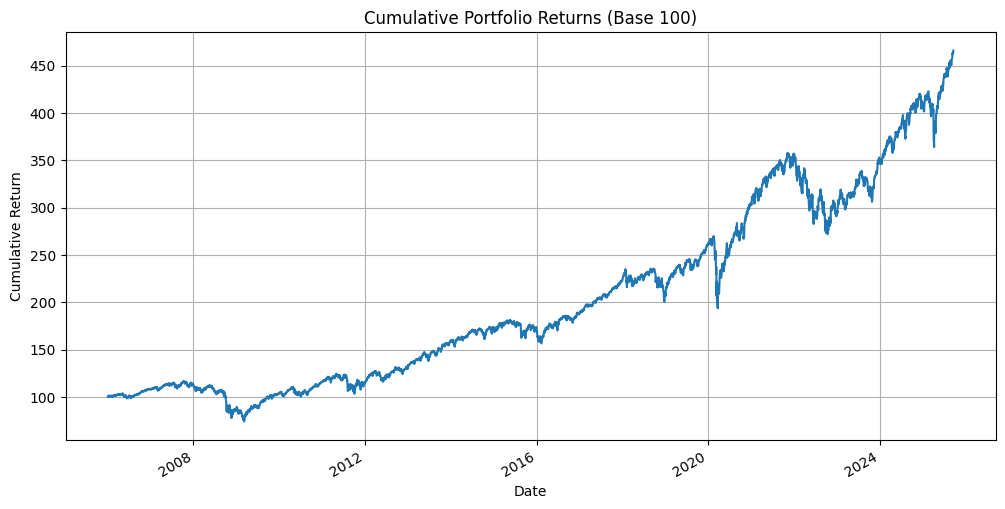

,NAV
Date,
2025-09-15,4.642542
2025-09-16,4.639683
2025-09-17,4.634979
2025-09-18,4.650943
2025-09-19,4.658562


Ticker,BND,VTI,VXUS
Date,,,
2025-09-15,0.195771,0.599234,0.204995
2025-09-16,0.195918,0.598794,0.205288
2025-09-17,0.195776,0.598867,0.205357
2025-09-18,0.194607,0.600574,0.204819
2025-09-19,0.194367,0.601846,0.203787


,Turnover
Date,
2025-09-15,0.0
2025-09-16,0.0
2025-09-17,0.0
2025-09-18,0.0
2025-09-19,0.0


/tmp/ipython-input-1586109035.py:127: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_returns = (1 + daily_returns).resample('Y').prod() - 1
/tmp/ipython-input-1586109035.py:128: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_std_dev = daily_returns.resample('Y').std() * np.sqrt(252) # Annualize daily std dev
/tmp/ipython-input-1586109035.py:134: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_max_drawdown = daily_drawdown.resample('Y').min()
/tmp/ipython-input-1586109035.py:137: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_turnover = turnover.resample('Y').sum()
/tmp/ipython-input-1586109035.py:142: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_rebalance_costs = daily_costs.resample('

,Annual Return,Annual Std Dev,Max Drawdown,Annual Turnover,Annual Rebalance Costs
Date,,,,,
2006-12-31,8.26%,6.21%,-5.14%,0.04,0.0012%
2007-12-31,4.59%,9.20%,-5.50%,0.08,0.0023%
2008-12-31,-22.57%,22.92%,-33.41%,0.14,0.0043%
2009-12-31,17.76%,15.75%,-36.47%,0.11,0.0032%
2010-12-31,12.03%,10.74%,-14.06%,0.11,0.0032%
2011-12-31,-0.67%,19.09%,-16.98%,0.07,0.0021%
2012-12-31,14.21%,10.90%,-8.80%,0.06,0.0018%
2013-12-31,21.86%,9.34%,-6.43%,0.07,0.0020%
2014-12-31,7.66%,8.86%,-6.41%,0.05,0.0016%


In [114]:
# === Example Usage ===
# Define your SAA and run everything end-to-end.
# You can replace the tickers & weights with your own.

SAA = {
    'VTI': 0.60,   # US equities
    'VXUS': 0.20,  # Intl ex-US equities
    'BND': 0.20,   # US aggregate bonds
}

result = build_proxy_benchmark(
    tickers=SAA,
    start='2006-01-01',
    end=None,                 # up to latest
    rebalance='monthly',      # none|monthly|quarterly|annual
    costs_bps=3.0,            # 3 bps per one-way turnover on rebalance days
    price_field='Adj Close',
)

# Inspect outputs
display(result.port_nav.tail())
display(result.weights.tail())
display(result.turnover.tail())

# Calculate and display the annual summary
annual_summary = calculate_annual_metrics(result)
display(annual_summary)





In [115]:
# Factor analysis using ETF proxies
fa = factor_analysis_etf(result.port_ret, max_factors=15) # Increased max_factors
plot_rolling_exposures(result.port_ret, fa['X'])
interpret_ols_results_markdown(fa['ols'], fa['vif'])

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GLD']: Timeout('Failed to perform, curl: (28) Connection timed out after 10001 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
/tmp/ipython-input-3271379798.py:37: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = px.ffill().pct_change().dropna(how="any")


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# Factor analysis using FF Factor
fa = factor_analysis_ff(result.port_ret, start='2006-01-01') # Increased max_factors
plot_rolling_exposures(result.port_ret, fa['X'])
interpret_ols_results_markdown(fa['ols'])

In [118]:
# ============================================
# Proxy Benchmark + Factor Analysis Toolkit
# ============================================
# - Step 1: Build Proxy Benchmark (SAA) with rebalancing, costs, turnover
# - Step 2: Factor Analysis:
#       universe="etf" -> ETF proxies
#       universe="ff"  -> Fama-French 5 + Momentum (daily)
#   Each supports mode="ols" or mode="lasso_ols" (LassoCV -> OLS+NW)
# ============================================

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm

from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# -----------------------------
# General utilities
# -----------------------------

def normalize_weights(w: Dict[str, float]) -> Dict[str, float]:
    s = float(sum(w.values()))
    if s == 0:
        raise ValueError("All input weights are zero.")
    return {k: v / s for k, v in w.items()}

def to_period_end_index(idx: pd.DatetimeIndex, freq: str) -> List[pd.Timestamp]:
    """Return rebalance dates (period ends) from a date index for given freq."""
    f = freq.lower()
    if f in ["none", "never", "n"]:
        return []
    if f in ["monthly", "m"]:
        return pd.Series(1, index=idx).resample("M").last().index.tolist()
    if f in ["quarterly", "q"]:
        return pd.Series(1, index=idx).resample("Q").last().index.tolist()
    if f in ["annual", "a", "y", "yearly"]:
        return pd.Series(1, index=idx).resample("Y").last().index.tolist()
    raise ValueError("rebalance must be one of {'none','monthly','quarterly','annual'}")

def compute_turnover(w_from: pd.Series, w_to: pd.Series) -> float:
    """One-way turnover to go from end-of-day weights -> target weights."""
    w_from = w_from.fillna(0.0)
    w_to = w_to.fillna(0.0).reindex(w_from.index).fillna(0.0)
    return 0.5 * np.abs(w_to - w_from).sum()

def apply_tc_to_return(turnover: float, day_ret: float, costs_bps: float) -> float:
    """Apply one-way transaction cost in bps to daily return on rebalance days."""
    tc = (costs_bps / 1e4) * turnover
    return day_ret - tc

def _safe_select_price_field(data: pd.DataFrame, price_field: str, tickers: List[str]) -> pd.DataFrame:
    """Handle yfinance MultiIndex vs single-level columns robustly."""
    if isinstance(data.columns, pd.MultiIndex):
        if price_field not in data.columns.get_level_values(0):
            raise KeyError(f"Requested price_field '{price_field}' not found in yfinance output.")
        px = data[price_field].copy()
        existing = [t for t in tickers if t in px.columns]
        if not existing:
            raise KeyError("None of the requested tickers found in the downloaded data for the given price field.")
        px = px[existing]
    else:
        if price_field in data.columns:
            px = data[[price_field]].copy()
            if len(tickers) == 1:
                px.columns = [tickers[0]]
        else:
            if set(tickers).issubset(set(data.columns)):
                px = data[tickers].copy()
            else:
                raise KeyError(f"Could not locate '{price_field}' or the tickers directly in columns.")
    return px

# -----------------------------
# STEP 1: Proxy Benchmark
# -----------------------------

@dataclass
class ProxyBenchmarkResult:
    prices: pd.DataFrame
    returns: pd.DataFrame
    port_ret: pd.Series
    port_nav: pd.Series
    weights: pd.DataFrame
    turnover: pd.Series
    rebalanced_on: pd.Series

def build_proxy_benchmark(
    tickers: Dict[str, float],
    start: str = "2015-01-01",
    end: Optional[str] = None,
    rebalance: str = "monthly",   # 'none', 'monthly', 'quarterly', 'annual'
    costs_bps: float = 0.0,
    price_field: str = "Adj Close",
    dropna: bool = True,
    plot: bool = True,
) -> ProxyBenchmarkResult:
    """
    Build a proxy benchmark from a Strategic Asset Allocation (SAA).
    Rebalances at period end (at close); applies one-way costs on rebalance days.
    """
    tickers = normalize_weights(tickers)
    tickers_list = list(tickers.keys())

    data = yf.download(tickers_list, start=start, end=end, auto_adjust=False, progress=False)
    prices = _safe_select_price_field(data, price_field=price_field, tickers=tickers_list)

    prices = prices.dropna(how="all")
    rets = prices.pct_change().fillna(0.0)
    if dropna:
        rets = rets.dropna(how="any")

    dates = rets.index
    target_w = pd.Series(tickers, dtype=float).reindex(rets.columns).fillna(0.0)
    w = target_w.copy()
    weights_hist: List[np.ndarray] = []
    port_ret: List[float] = []
    turnover_hist: List[float] = []
    rb_dates = set(to_period_end_index(dates, rebalance))

    for dt in dates:
        day_ret = float((w * rets.loc[dt]).sum())

        if dt in rb_dates and rebalance.lower() not in ["none", "never", "n"]:
            end_values = (1.0 + rets.loc[dt]) * w
            end_weights = end_values / end_values.sum()
            t = compute_turnover(end_weights, target_w)
            turnover_hist.append(t)
            day_ret = apply_tc_to_return(t, day_ret, costs_bps)
            w = target_w.copy()
        else:
            turnover_hist.append(0.0)
            end_values = (1.0 + rets.loc[dt]) * w
            w = end_values / end_values.sum()

        port_ret.append(day_ret)
        weights_hist.append(w.values)

    port_ret = pd.Series(port_ret, index=dates, name="PortfolioReturn")
    nav = (1.0 + port_ret).cumprod().rename("NAV")
    weights_df = pd.DataFrame(weights_hist, index=dates, columns=rets.columns)
    turnover = pd.Series(turnover_hist, index=dates, name="Turnover")
    rebalanced_on = pd.Series([dt in rb_dates for dt in dates], index=dates, name="Rebalanced")

    if plot:
        plt.figure(figsize=(12, 6))
        ((1.0 + port_ret).cumprod() * 100.0).plot()
        plt.title("Cumulative Portfolio Returns (Base 100)")
        plt.xlabel("Date"); plt.ylabel("Cumulative Return")
        plt.grid(True); plt.tight_layout(); plt.show()

    return ProxyBenchmarkResult(
        prices=prices,
        returns=rets,
        port_ret=port_ret,
        port_nav=nav,
        weights=weights_df,
        turnover=turnover,
        rebalanced_on=rebalanced_on,
    )

def calculate_annual_metrics(result: ProxyBenchmarkResult, assumed_costs_bps: float = 3.0) -> pd.DataFrame:
    """Annual performance metrics for the built portfolio."""
    daily_returns = result.port_ret
    nav = result.port_nav
    turnover = result.turnover

    annual_returns = (1.0 + daily_returns).resample("Y").prod() - 1.0
    annual_std_dev = daily_returns.resample("Y").std() * np.sqrt(252.0)

    roll_max = nav.cummax()
    daily_drawdown = nav / roll_max - 1.0
    annual_max_drawdown = daily_drawdown.resample("Y").min()

    annual_turnover = turnover.resample("Y").sum()
    daily_costs = turnover * (assumed_costs_bps / 10000.0)
    annual_rebalance_costs = daily_costs.resample("Y").sum()

    summary_df = pd.DataFrame({
        "Annual Return": annual_returns,
        "Annual Std Dev": annual_std_dev,
        "Max Drawdown": annual_max_drawdown,
        "Annual Turnover": annual_turnover,
        "Annual Rebalance Costs": annual_rebalance_costs,
    })

    summary_df["Annual Return"] = summary_df["Annual Return"].map("{:.2%}".format)
    summary_df["Annual Std Dev"] = summary_df["Annual Std Dev"].map("{:.2%}".format)
    summary_df["Max Drawdown"] = summary_df["Max Drawdown"].map("{:.2%}".format)
    summary_df["Annual Turnover"] = summary_df["Annual Turnover"].map("{:.2f}".format)
    summary_df["Annual Rebalance Costs"] = summary_df["Annual Rebalance Costs"].map("{:.4%}".format)

    return summary_df

# -----------------------------
# STEP 2: Factor Analysis
# -----------------------------

ETF_FACTOR_PROXIES: Dict[str, str] = {
    # Equity styles
    "MTUM": "US Momentum",
    "VLUE": "US Value",
    "QUAL": "US Quality",
    "SIZE": "US Small Size (IJR)",
    "USMV": "US Min Vol (USMV)",
    # Regions / broad beta
    "SPY":  "US Equity Beta",
    "VEA":  "DM ex-US Equity",
    "VWO":  "EM Equity",
    # Rates / credit
    "IEF":  "US 7-10Y Treasury",
    "TLT":  "US 20+Y Treasury",
    "LQD":  "US IG Credit",
    "HYG":  "US HY Credit",
    # Real assets / commodities / FX
    "GLD":  "Gold",
    "DBC":  "Broad Commodities",
    "UUP":  "US Dollar (DXY proxy)",
}

def fetch_returns(tickers: List[str], start: str, end: Optional[str] = None, price_field: str = "Adj Close") -> pd.DataFrame:
    data = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=False)
    px = _safe_select_price_field(data, price_field=price_field, tickers=tickers)
    rets = px.ffill().pct_change().dropna(how="any")
    return rets

def ols_factor_regression(y: pd.Series, X: pd.DataFrame, add_const: bool = True):
    X_ = X.copy()
    if add_const:
        X_ = sm.add_constant(X_)
    model = sm.OLS(y, X_, missing="drop").fit()
    return model

def compute_vif(X: pd.DataFrame) -> pd.Series:
    """Variance Inflation Factors to diagnose multicollinearity."""
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    X_ = sm.add_constant(X)
    vifs = []
    for i in range(1, X_.shape[1]):  # skip constant
        vifs.append(variance_inflation_factor(X_.values, i))
    return pd.Series(vifs, index=X.columns, name="VIF")

# ---- Lasso -> OLS (HAC) helpers ----

def _nw_lags(T: int) -> int:
    """Newey–West maxlags simple rule-of-thumb."""
    return max(1, int(np.floor(4 * (T / 100.0) ** (2.0 / 9.0))))

def _standardize_xy(y: pd.Series, X: pd.DataFrame) -> Tuple[pd.Series, pd.DataFrame, StandardScaler]:
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xs = pd.DataFrame(scaler.fit_transform(X.values), index=X.index, columns=X.columns)
    return y.copy(), Xs, scaler

def _tidy_result_table(model: sm.regression.linear_model.RegressionResultsWrapper) -> pd.DataFrame:
    summ = pd.DataFrame({
        "coef": model.params,
        "t": model.tvalues,
        "pval": model.pvalues
    })
    return summ

def lasso_select_factors(
    y: pd.Series,
    X: pd.DataFrame,
    n_splits: int = 5,
    alphas: Optional[np.ndarray] = None,
    max_iter: int = 5000,
    random_state: int = 42,
) -> Dict:
    # Align & drop NA
    common = y.index.intersection(X.index)
    y_ = y.loc[common].astype(float)
    X_ = X.loc[common].astype(float)
    X_ = X_.dropna(how="any")
    y_ = y_.reindex(X_.index).dropna()
    X_ = X_.reindex(y_.index)

    # Standardize X (not y)
    y_s, Xs, scaler = _standardize_xy(y_, X_)

    # Time-series aware CV
    tscv = TimeSeriesSplit(n_splits=n_splits)
    if alphas is None:
        alphas = np.logspace(-4, 0, 50)

    lcv = LassoCV(
        alphas=alphas,
        cv=tscv,
        fit_intercept=True,
        max_iter=max_iter,
        random_state=random_state
    )
    lcv.fit(Xs.values, y_s.values)

    coefs = pd.Series(lcv.coef_, index=Xs.columns)
    selected = coefs[coefs != 0.0].index.tolist()

    return {
        "selected_factors": selected,
        "coefs_stdX": coefs,
        "alpha_": lcv.alpha_,
        "mse_path_": lcv.mse_path_,
        "alphas_": lcv.alphas_,
        "scaler": scaler,
        "X_std": Xs,
        "y": y_,
        "X": X_,
    }

def refit_ols_newey_west(y: pd.Series, X: pd.DataFrame, add_const: bool = True):
    y_ = y.copy()
    X_ = X.copy()
    if add_const:
        X_ = sm.add_constant(X_)
    model = sm.OLS(y_, X_, missing="drop").fit(cov_type="HAC", cov_kwds={"maxlags": _nw_lags(len(y_))})
    return model

# ---- ETF factor analysis (unchanged) ----

def factor_analysis_etf(
    port_ret: pd.Series,
    start: Optional[str] = None,
    end: Optional[str] = None,
    factor_universe: Optional[Dict[str, str]] = None,
    max_factors: int = 12,
    mode: str = "ols",   # "ols" or "lasso_ols"
    n_splits: int = 5,
    alphas: Optional[np.ndarray] = None,
    price_field: str = "Adj Close",
) -> Dict:
    if factor_universe is None:
        factor_universe = ETF_FACTOR_PROXIES

    tickers = list(factor_universe.keys())[:max_factors]
    X = fetch_returns(tickers, start or str(port_ret.index.min().date()), end, price_field=price_field)

    # Align
    y = port_ret.reindex(X.index).dropna()
    X = X.reindex(y.index)

    out = {"X": X, "y": y, "mode": mode, "universe": "etf"}

    if mode.lower() == "ols":
        ols_model = ols_factor_regression(y, X, add_const=True)
        vif = compute_vif(X)
        out.update({
            "ols": ols_model,
            "vif": vif,
            "r2": ols_model.rsquared,
            "adj_r2": ols_model.rsquared_adj,
            "table": _tidy_result_table(ols_model)
        })
        return out

    elif mode.lower() == "lasso_ols":
        sel = lasso_select_factors(y, X, n_splits=n_splits, alphas=alphas)
        selected = sel["selected_factors"]

        if len(selected) == 0:
            ols_model = ols_factor_regression(y, X, add_const=True)
            vif = compute_vif(X)
            out.update({
                "selection": sel,
                "ols": ols_model,
                "vif": vif,
                "r2": ols_model.rsquared,
                "adj_r2": ols_model.rsquared_adj,
                "table": _tidy_result_table(ols_model),
                "note": "Lasso selected no factors; reverted to OLS on full set."
            })
            return out

        X_sel = X[selected]
        ols_nw = refit_ols_newey_west(y, X_sel, add_const=True)
        vif_sel = compute_vif(X_sel) if X_sel.shape[1] >= 2 else pd.Series(dtype=float)

        out.update({
            "selection": sel,
            "selected_factors": selected,
            "ols": ols_nw,
            "vif": vif_sel,
            "r2": ols_nw.rsquared,
            "adj_r2": ols_nw.rsquared_adj,
            "table": _tidy_result_table(ols_nw)
        })
        return out

    else:
        raise ValueError("mode must be one of {'ols','lasso_ols'}")

# ---- Fama-French 5 + Momentum (daily) ----

def fetch_famafrench_5_mom_daily(start: Optional[str] = None, end: Optional[str] = None) -> pd.DataFrame:
    """
    Fetch daily Fama-French 5 factors + Momentum:
      - 'F-F_Research_Data_5_Factors_2x3_Daily'
      - 'F-F_Momentum_Factor_Daily'
    Returns columns in decimal: ['MKT_RF','SMB','HML','RMW','CMA','MOM','RF']
    """
    try:
        from pandas_datareader import data as web
    except Exception as e:
        raise ImportError(
            "pandas_datareader is required to fetch Fama-French factors. "
            "Install with: pip install pandas_datareader"
        ) from e

    ff5 = web.DataReader('F-F_Research_Data_5_Factors_2x3_Daily', 'famafrench')[0]
    mom = web.DataReader('F-F_Momentum_Factor_Daily', 'famafrench')[0]

    # Clean column names (strip spaces), convert to decimal
    ff5.columns = [c.strip() for c in ff5.columns]
    mom.columns = [c.strip() for c in mom.columns]

    # Join and standardize names
    df = ff5.join(mom, how='inner')
    # Rename to consistent schema
    rename_map = {
        'Mkt-RF': 'MKT_RF',
        'SMB': 'SMB',
        'HML': 'HML',
        'RMW': 'RMW',
        'CMA': 'CMA',
        'RF': 'RF',
        'Mom': 'MOM',
        'Mom   ': 'MOM',
        'UMD': 'MOM',  # sometimes momentum column labeled differently
    }
    df = df.rename(columns=rename_map)
    # Keep only expected columns if present
    keep = [c for c in ['MKT_RF','SMB','HML','RMW','CMA','MOM','RF'] if c in df.columns]
    df = df[keep]

    # Convert index to DatetimeIndex and filter dates
    df.index = pd.to_datetime(df.index)

    if start is not None:
        df = df[df.index >= pd.to_datetime(start)]
    if end is not None:
        df = df[df.index <= pd.to_datetime(end)]

    # Percent to decimal
    df = df / 100.0
    return df

def factor_analysis_ff(
    port_ret: pd.Series,
    start: Optional[str] = None,
    end: Optional[str] = None,
    use_excess: bool = True,      # regress excess returns over RF
    mode: str = "ols",
    n_splits: int = 5,
    alphas: Optional[np.ndarray] = None,
) -> Dict:
    """
    Fama-French 5 + Momentum (daily) factor regression.
    If use_excess=True, regress (port_ret - RF) on [MKT_RF, SMB, HML, RMW, CMA, MOM] (+ const for alpha).
    """
    ff = fetch_famafrench_5_mom_daily(start or str(port_ret.index.min().date()), end)

    # Align to portfolio dates
    y = port_ret.reindex(ff.index).dropna()
    ff = ff.reindex(y.index).dropna()

    if use_excess:
        if 'RF' not in ff.columns:
            raise ValueError("RF not found in Fama-French dataset; cannot compute excess returns.")
        y_ex = y - ff['RF']
        y_used = y_ex
    else:
        y_used = y

    # X factors (exclude RF)
    factor_cols = [c for c in ['MKT_RF','SMB','HML','RMW','CMA','MOM'] if c in ff.columns]
    X = ff[factor_cols]

    out = {"X": X, "y": y_used, "mode": mode, "universe": "ff", "use_excess": use_excess}

    if mode.lower() == "ols":
        ols_model = ols_factor_regression(y_used, X, add_const=True)
        vif = compute_vif(X)
        out.update({
            "ols": ols_model,
            "vif": vif,
            "r2": ols_model.rsquared,
            "adj_r2": ols_model.rsquared_adj,
            "table": _tidy_result_table(ols_model)
        })
        return out

    elif mode.lower() == "lasso_ols":
        sel = lasso_select_factors(y_used, X, n_splits=n_splits, alphas=alphas)
        selected = sel["selected_factors"]

        if len(selected) == 0:
            ols_model = ols_factor_regression(y_used, X, add_const=True)
            vif = compute_vif(X)
            out.update({
                "selection": sel,
                "ols": ols_model,
                "vif": vif,
                "r2": ols_model.rsquared,
                "adj_r2": ols_model.rsquared_adj,
                "table": _tidy_result_table(ols_model),
                "note": "Lasso selected no factors; reverted to OLS on full FF set."
            })
            return out

        X_sel = X[selected]
        ols_nw = refit_ols_newey_west(y_used, X_sel, add_const=True)
        vif_sel = compute_vif(X_sel) if X_sel.shape[1] >= 2 else pd.Series(dtype=float)

        out.update({
            "selection": sel,
            "selected_factors": selected,
            "ols": ols_nw,
            "vif": vif_sel,
            "r2": ols_nw.rsquared,
            "adj_r2": ols_nw.rsquared_adj,
            "table": _tidy_result_table(ols_nw)
        })
        return out

    else:
        raise ValueError("mode must be one of {'ols','lasso_ols'}")

# ---- Unified switcher ----

def factor_analysis(
    port_ret: pd.Series,
    universe: str = "etf",   # "etf" or "ff"
    **kwargs
) -> Dict:
    """
    Unified entrypoint:
        universe="etf" -> factor_analysis_etf(...)
        universe="ff"  -> factor_analysis_ff(...)
    Pass the same kwargs (start, end, mode, etc.) as appropriate.
    """
    uni = universe.lower()
    if uni == "etf":
        return factor_analysis_etf(port_ret=port_ret, **kwargs)
    elif uni == "ff":
        return factor_analysis_ff(port_ret=port_ret, **kwargs)
    else:
        raise ValueError("universe must be one of {'etf','ff'}")

# -----------------------------
# Rolling exposures
# -----------------------------

def plot_rolling_exposures(port_ret: pd.Series, X: pd.DataFrame, window: int = 126):
    """Compute and plot rolling OLS betas vs selected factors."""
    common = port_ret.index.intersection(X.index)
    y = port_ret.reindex(common)
    Xc = X.reindex(common)
    betas = []
    idx = []
    for i in range(window, len(common)):
        y_w = y.iloc[i-window:i]
        X_w = Xc.iloc[i-window:i]
        m = ols_factor_regression(y_w, X_w, add_const=False)
        betas.append(pd.Series(m.params, index=X.columns))
        idx.append(common[i])

    betas_df = pd.DataFrame(betas, index=idx)

    for col in betas_df.columns:
        plt.figure(figsize=(10, 4))
        betas_df[col].plot()
        plt.title(f"Rolling {window}-day Beta vs {col}")
        plt.xlabel("Date"); plt.ylabel("Beta")
        plt.grid(True); plt.tight_layout(); plt.show()
    return betas_df



/tmp/ipython-input-2643164840.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.Series(1, index=idx).resample("M").last().index.tolist()


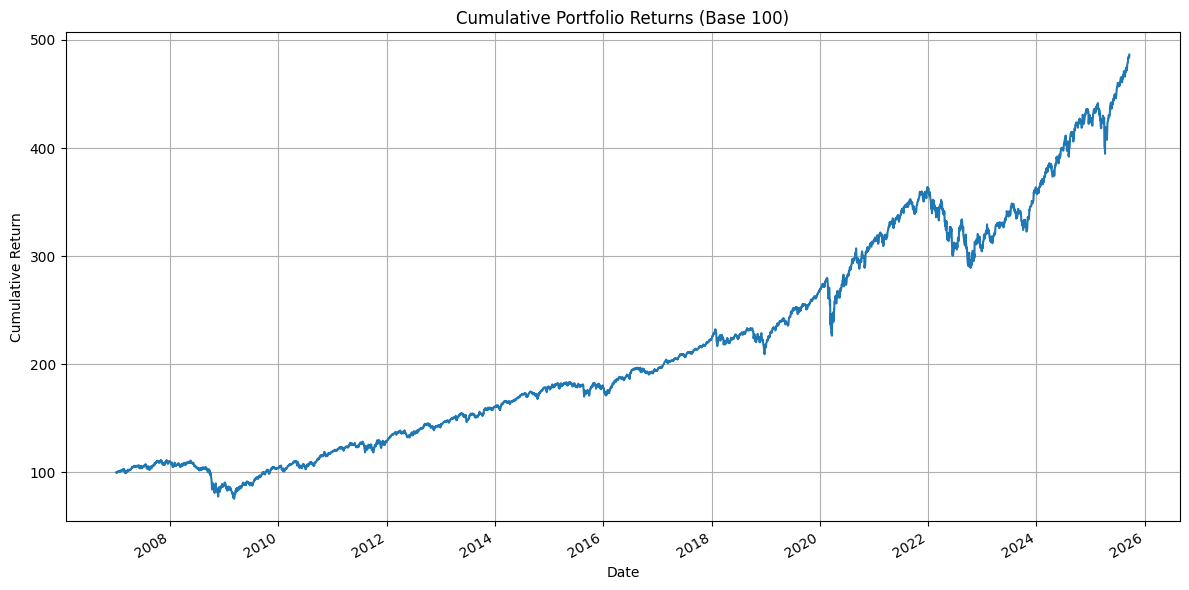

/tmp/ipython-input-2643164840.py:176: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_returns = (1.0 + daily_returns).resample("Y").prod() - 1.0
/tmp/ipython-input-2643164840.py:177: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_std_dev = daily_returns.resample("Y").std() * np.sqrt(252.0)
/tmp/ipython-input-2643164840.py:181: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_max_drawdown = daily_drawdown.resample("Y").min()
/tmp/ipython-input-2643164840.py:183: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_turnover = turnover.resample("Y").sum()
/tmp/ipython-input-2643164840.py:185: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_rebalance_costs = daily_costs.resample("Y").sum()


           Annual Return Annual Std Dev Max Drawdown Annual Turnover  \
Date                                                                   
2007-12-31         9.54%          9.48%       -4.90%            0.09   
2008-12-31       -18.76%         22.28%      -30.25%            0.19   
2009-12-31        15.93%         15.28%      -32.10%            0.13   
2010-12-31        15.43%         10.18%       -9.35%            0.11   
2011-12-31         7.53%         11.97%       -7.90%            0.12   
2012-12-31        11.34%          7.41%       -4.69%            0.07   
2013-12-31        12.73%          7.48%       -5.48%            0.10   
2014-12-31        10.63%          6.21%       -3.86%            0.05   
2015-12-31         0.32%          8.84%       -7.26%            0.07   
2016-12-31         8.70%          6.95%       -6.77%            0.10   
2017-12-31        14.85%          3.87%       -1.54%            0.05   
2018-12-31        -2.29%          9.68%      -10.40%            

/tmp/ipython-input-2643164840.py:416: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5 = web.DataReader('F-F_Research_Data_5_Factors_2x3_Daily', 'famafrench')[0]
/tmp/ipython-input-2643164840.py:417: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom = web.DataReader('F-F_Momentum_Factor_Daily', 'famafrench')[0]


FF selected factors: ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']
FF R^2: 0.9146 | Adj R^2: 0.9142
            coef          t      pval
const  -0.000027  -0.479161  0.631824
MKT_RF  0.602876  66.705922  0.000000
SMB    -0.033026  -3.384573  0.000713
HML    -0.043456  -3.496716  0.000471
RMW     0.052874   4.309507  0.000016
CMA     0.066936   3.774397  0.000160
MOM    -0.021313  -2.865330  0.004166


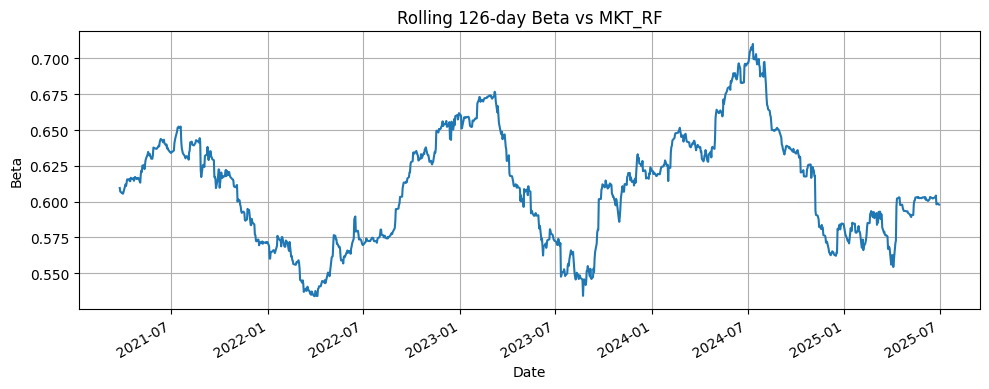

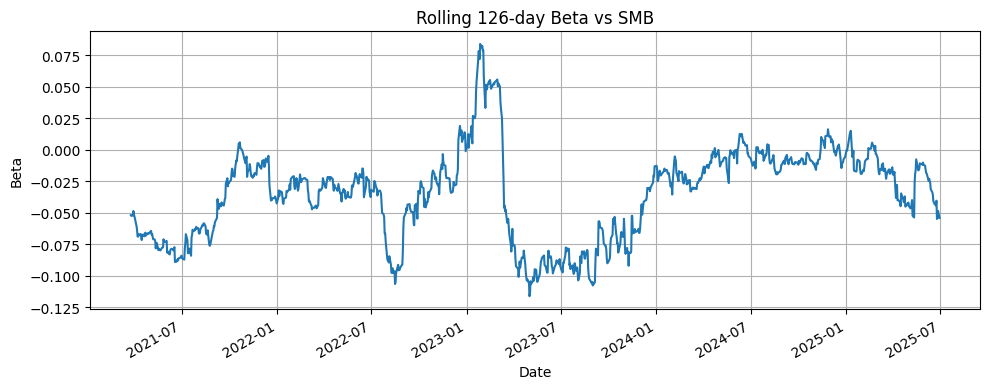

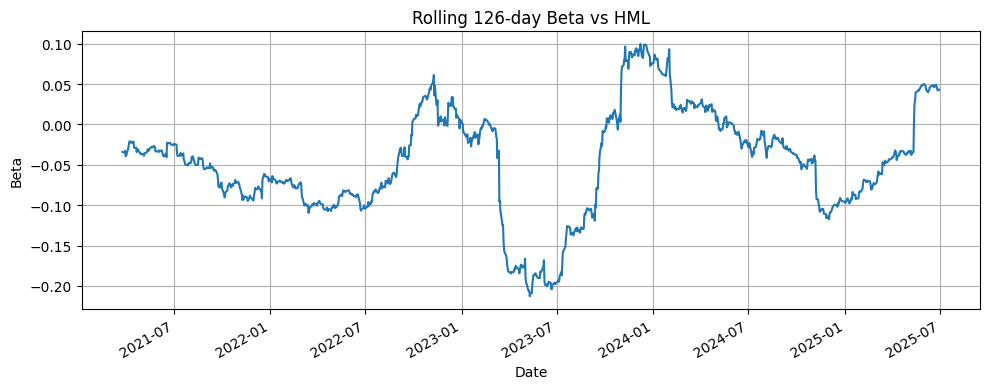

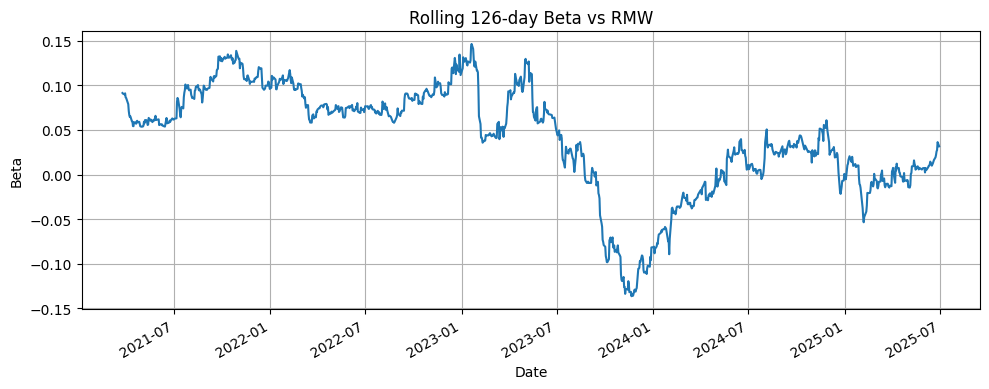

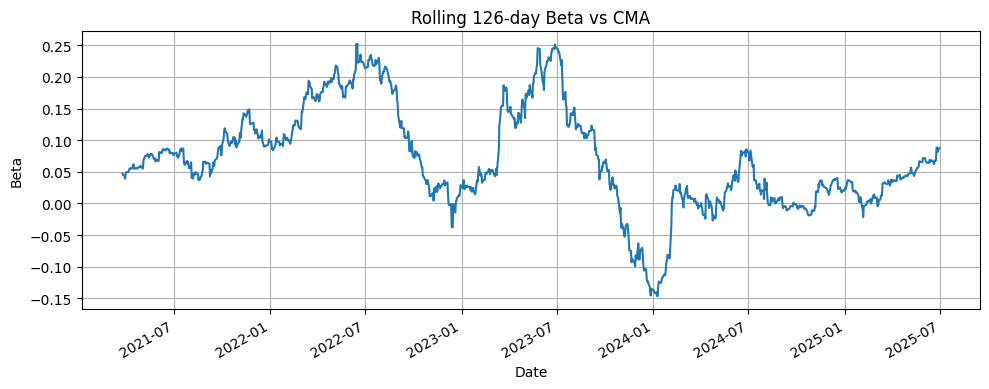

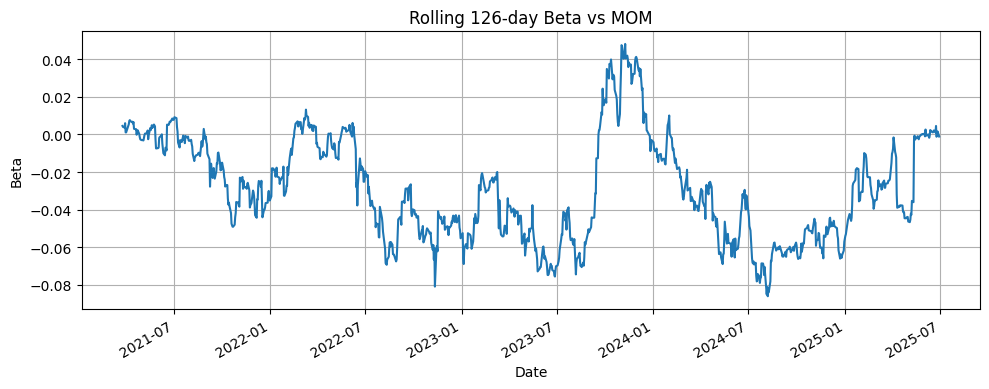

In [121]:
# --------------------------------
# Example usage (comment/uncomment)
# --------------------------------
if __name__ == "__main__":
    # Step 1: Build proxy benchmark
    saa = {"SPY": 0.6, "IEF": 0.3, "GLD": 0.1}
    res = build_proxy_benchmark(
        tickers=saa,
        start="2007-01-01",
        rebalance="monthly",
        costs_bps=3.0,
        price_field="Adj Close",
        dropna=True,
        plot=True
    )
    print(calculate_annual_metrics(res))

    # Step 2A: ETF factor analysis (Lasso -> OLS+NW)
    fa_etf = factor_analysis(
        port_ret=res.port_ret,
        universe="etf",
        start="2007-01-01",
        max_factors=12,
        mode="lasso_ols",
        n_splits=5
    )
    print("ETF selected factors:", fa_etf.get("selected_factors"))
    print(f"ETF R^2: {fa_etf['r2']:.4f} | Adj R^2: {fa_etf['adj_r2']:.4f}")
    print(fa_etf["table"])



/tmp/ipython-input-2643164840.py:416: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5 = web.DataReader('F-F_Research_Data_5_Factors_2x3_Daily', 'famafrench')[0]
/tmp/ipython-input-2643164840.py:417: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom = web.DataReader('F-F_Momentum_Factor_Daily', 'famafrench')[0]


FF selected factors: ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']
FF R^2: 0.9146 | Adj R^2: 0.9142
            coef          t      pval
const  -0.000027  -0.479161  0.631824
MKT_RF  0.602876  66.705922  0.000000
SMB    -0.033026  -3.384573  0.000713
HML    -0.043456  -3.496716  0.000471
RMW     0.052874   4.309507  0.000016
CMA     0.066936   3.774397  0.000160
MOM    -0.021313  -2.865330  0.004166


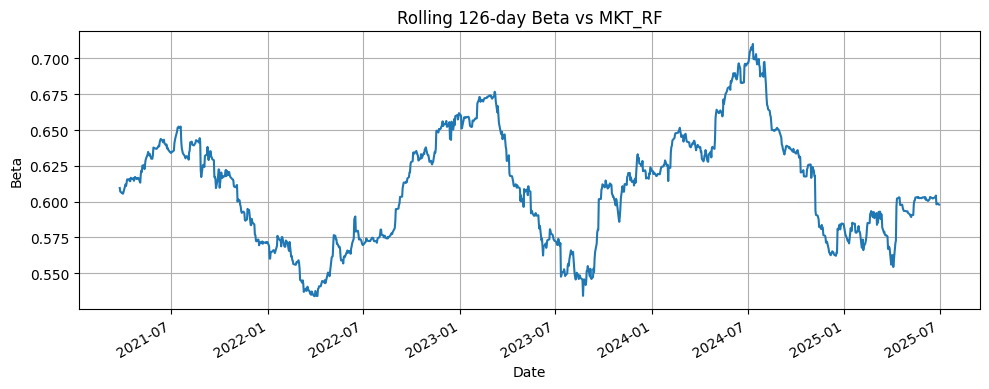

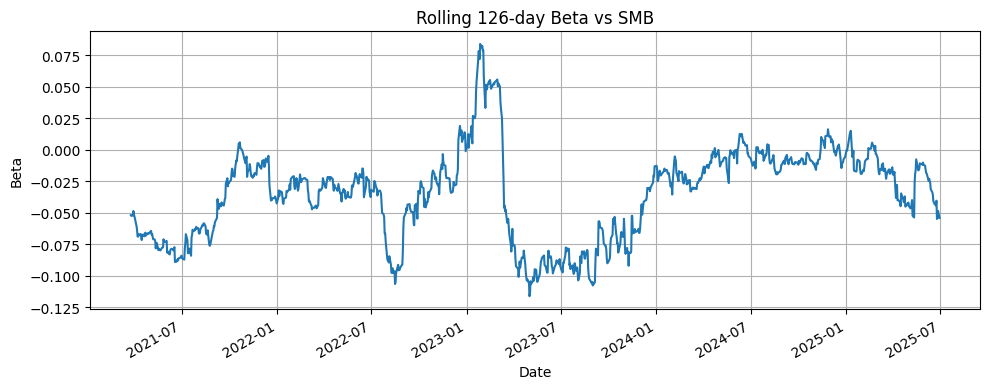

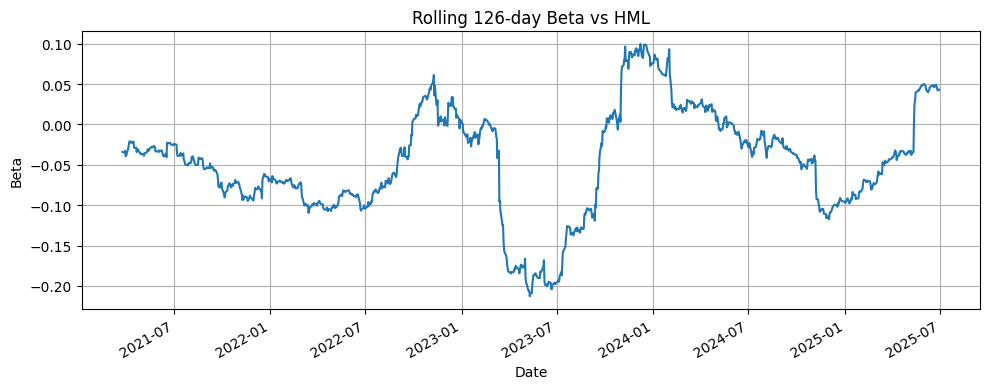

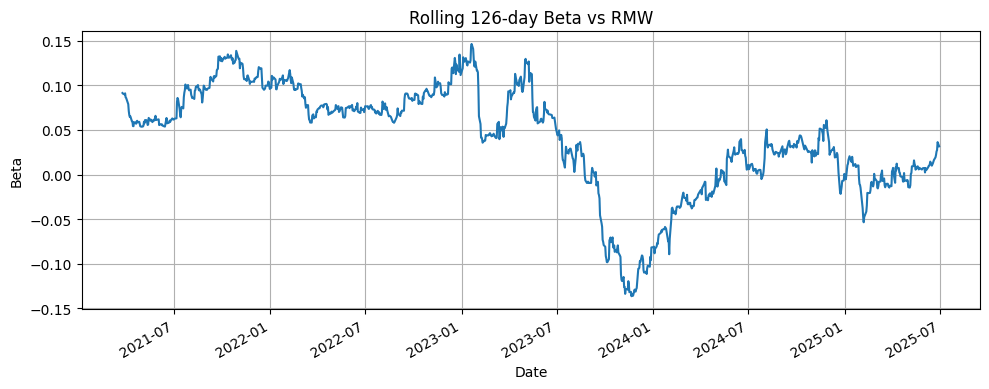

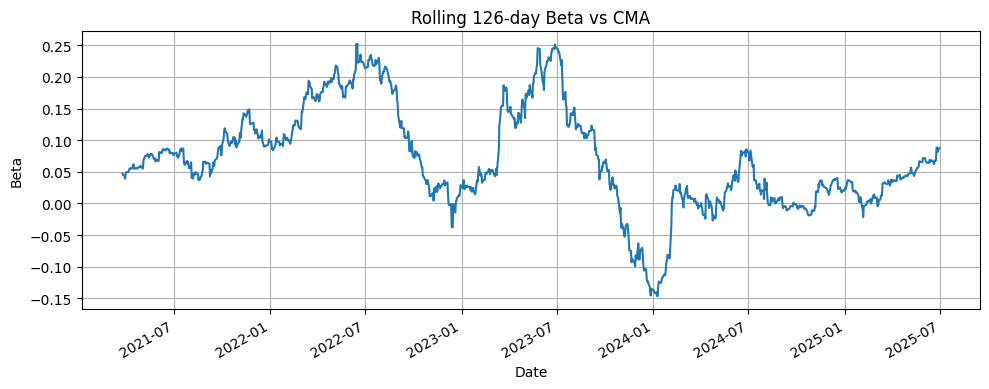

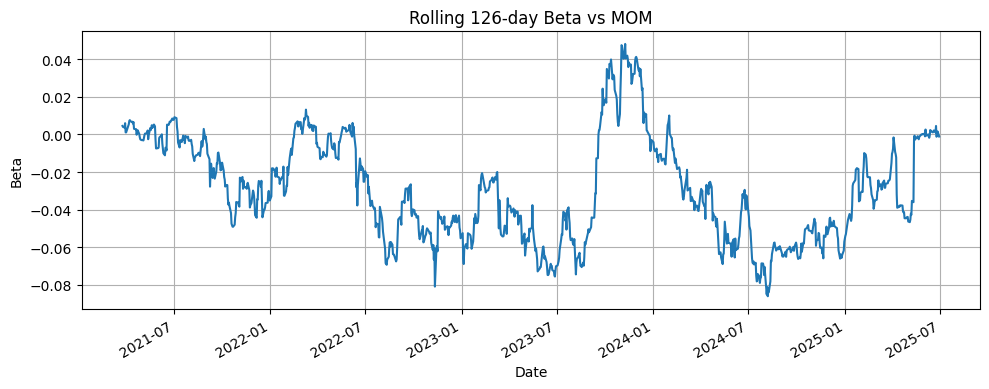

In [123]:
# Step 2B: Fama-French 5 + Momentum (daily), excess returns, Lasso -> OLS+NW
fa_ff = factor_analysis(
    port_ret=res.port_ret,
    universe="ff",
    start="2007-01-01",
    mode="lasso_ols",
    n_splits=5,
    use_excess=True
)
print("FF selected factors:", fa_ff.get("selected_factors"))
print(f"FF R^2: {fa_ff['r2']:.4f} | Adj R^2: {fa_ff['adj_r2']:.4f}")
print(fa_ff["table"])

# Rolling betas on whichever X you prefer:
Xsel = fa_ff["X"][fa_ff.get("selected_factors", fa_ff["X"].columns)]
_ = plot_rolling_exposures(res.port_ret, Xsel, window=126)
